<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalacion de paquetes**

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [1]:
!pip install mne

     |████████████████████████████████| 6.9 MB 4.7 MB/s 


# **Importa paquetes**



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
from scipy.signal import butter, lfilter
from sklearn import decomposition

from google.colab import drive
from google.colab import files

import sys
import mne

from scipy.signal import find_peaks
#from sklearn.cluster import KMeans

# Carga de datos

Se descarga el dataset y descomprime en `/content/procesados`.

In [3]:
raw_dataset_filename = "procesados-20210908T224817Z-001.zip"
raw_dataset_path     =  f'/content/{raw_dataset_filename}'
raw_dataset_url      =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{raw_dataset_filename}'
dataset_path         = "/content/procesados"

!rm -rf {dataset_path}
!rm -rf {raw_dataset_path}
!wget  {raw_dataset_url}
!unzip {raw_dataset_path}

sys.path.append(dataset_path)

--2021-09-14 17:18:17--  https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/procesados-20210908T224817Z-001.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7272780 (6.9M) [application/zip]
Saving to: ‘procesados-20210908T224817Z-001.zip’

procesados-20210908 100%[===================>]   6.94M  --.-KB/s    in 0.09s   

2021-09-14 17:18:17 (79.3 MB/s) - ‘procesados-20210908T224817Z-001.zip’ saved [7272780/7272780]

Archive:  /content/procesados-20210908T224817Z-001.zip
  inflating: procesados/suj_12_bl_2.txt  
  inflating: procesados/suj_8_bl_2.txt  
  inflating: procesados/suj_9_bl_1.txt  
  inflating: procesados/suj_8_bl_1.txt  
  inflating: procesados/suj_12_bl_1.txt  
  inflating: procesados/suj_13_bl_1.txt  
  inflating: procesado

## 1 - Lectura de datos de EEG

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo es de 256 Hz.

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [4]:
filename = '/content/procesados/suj_10_bl_1.txt'

datos    = pd.read_csv(filename, sep=',', header=None)
eeg_data = datos.to_numpy()
srate    = 128
ch       = eeg_data.shape[0]
samples  = eeg_data.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(eeg_data.shape[1], eeg_data.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 128.00 Hz
Data shape: 7681 samples x 30 channels
Tiempo total : 60.01 


Los registros fueron tomados con el montage 10-20.

**La nariz es fpz**.
Tengo que armarlo que los electrodos tengan esta distribución:
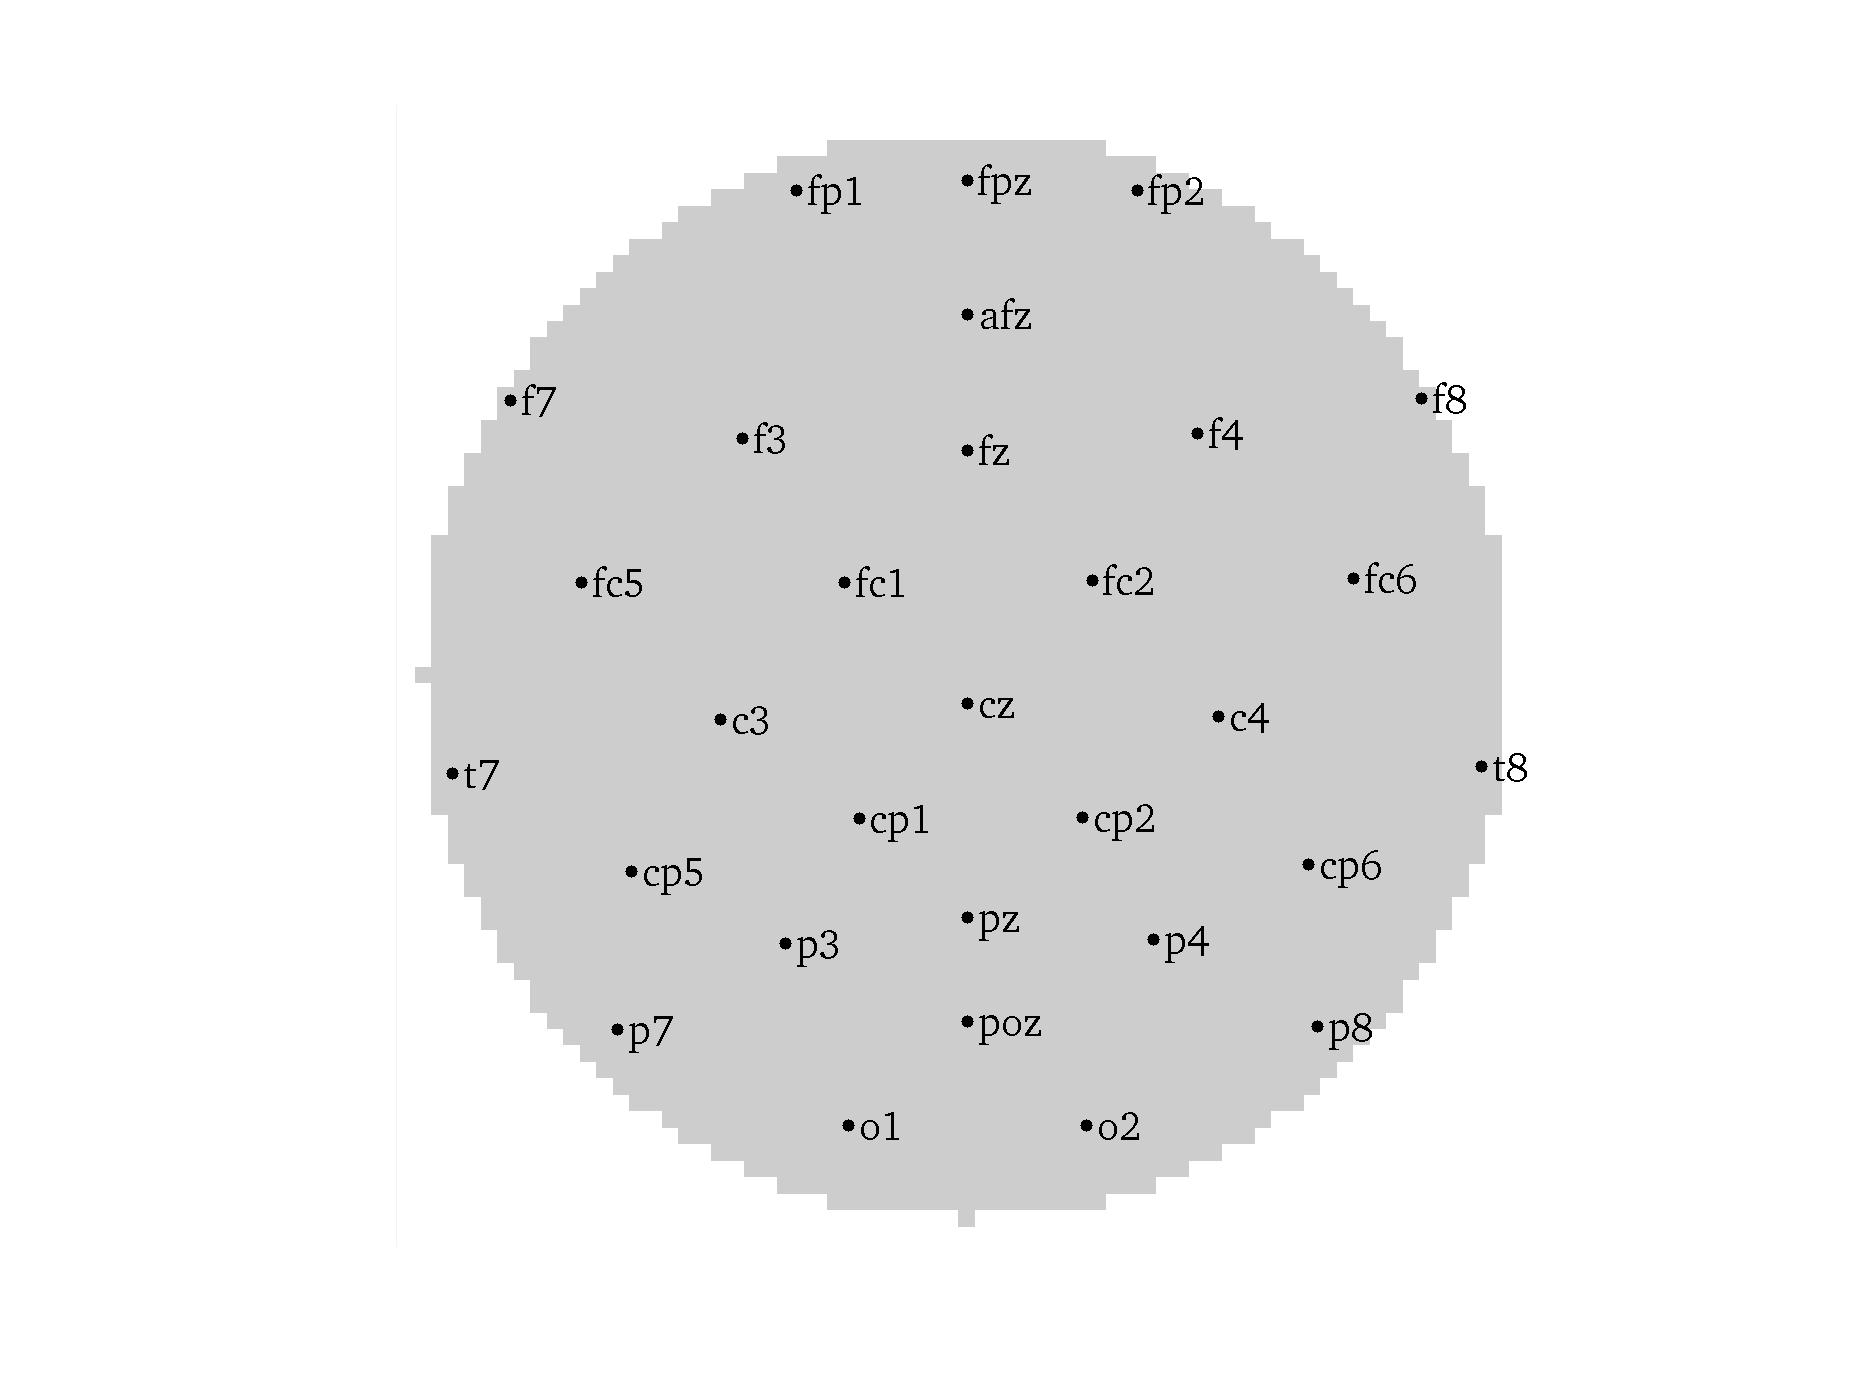

In [5]:
channels = [
    'Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
    'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
    'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz'
]

In [6]:
def get_info_eeg_and_montage(channels, montage_type='standard_1020'):
    montage = mne.channels.make_standard_montage(montage_type)

    ind = [i for (i, channel) in enumerate(montage.ch_names) if channel in channels]
    montage_30 = montage.copy()

    # Me quedo solo con los canales seleccionados
    montage_30.ch_names = [montage.ch_names[x] for x in ind]
    kept_channel_info    = [montage.dig[x+3] for x in ind]

    # Me quedo con las referencias desde dónde están ubicados los canales
    montage_30.dig = montage.dig[0:3]+kept_channel_info

    info_eeg= mne.create_info(
        ch_names = montage_30.ch_names, 
        sfreq    = 128,
        ch_types = 'eeg'
    ).set_montage(montage_30)

    return info_eeg, montage_30

In [7]:
info_eeg, mont1020_30 = get_info_eeg_and_montage(channels, 'standard_1020')
info_eeg

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, AFz, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, ...
 chs: 30 EEG
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 30
 projs: []
 sfreq: 128.0 Hz
>

# 1.b - Inspección de los datos EEG procesados

In [8]:
def show_data(egg_data, montage, srate):
    inicio = 1
    fin    = 10
    xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
    fig,ax = plt.subplots(ncols=1,figsize=(16,8))
    #fig.suptitle('Series temporales (uV)')
    yticks=[]
    for c in np.arange(ch):
        temp = egg_data[c,inicio*srate:fin*srate]
        dmin=np.min(temp)
        dmax=np.max(temp)
        vmedio = np.mean([dmin,dmax])+30*c
        yticks.append(vmedio)
        ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
    ax.set_xlim([inicio*srate,fin*srate])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(inicio,fin+1))
    ax.set_yticks(yticks)
    ax.set_yticklabels(montage.ch_names)
    ax.set_ylabel('channels')
    ax.set_xlabel('Time (s)')
    
    plt.show()

def show_data_diff(egg_data_a, egg_data_b, srate, montage):
    inicio = 1
    fin    = 4
    xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
    fig,ax = plt.subplots(ncols=1,figsize=(16,8))
    #fig.suptitle('Series temporales (uV)')
    yticks=[]
    for c in np.arange(ch):
        temp   = egg_data_a[c,inicio*srate:fin*srate]
        temp2  = egg_data_b[c,inicio*srate:fin*srate]
        dmin   = np.min(temp)
        dmax   = np.max(temp)
        vmedio = np.mean([dmin,dmax])+30*c
        yticks.append(vmedio)
        ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'--r')
        ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp2)+temp2,'k')
    ax.set_xlim([inicio*srate,fin*srate])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(inicio,fin+1))
    ax.set_yticks(yticks)
    ax.set_yticklabels(montage.ch_names)
    ax.set_ylabel('channels')
    ax.set_xlabel('Time (s)')
    
    plt.show()

    fig,ax=plt.subplots(ncols=1,figsize=(16,2))
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'--r')
    ax.plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp2)+temp2,'k')
    ax.set_xlim([inicio*srate,fin*srate])
    ax.set_xticks(xticks)
    ax.set_xticklabels(np.arange(inicio,fin+1))
    ax.set_yticks([860])
    ax.set_yticklabels(mont1020_30.ch_names[c-1])
    ax.set_ylabel('channels')
    ax.set_xlabel('Time (s)')

    plt.show()

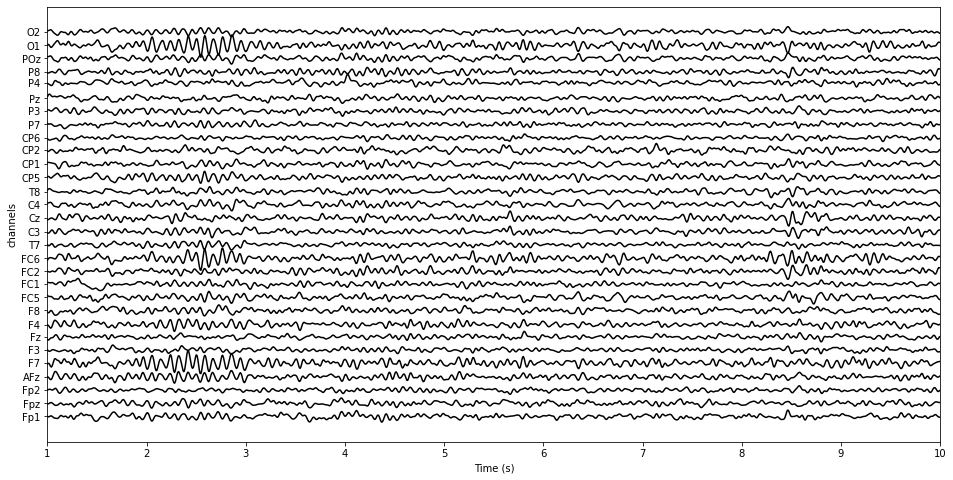

In [9]:
show_data(eeg_data, mont1020_30, srate)

Topología


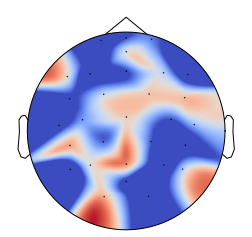

In [10]:
fig, ax = plt.subplots( figsize=(8, 4), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

inicio = 1
fin    = 4
im,cm  = mne.viz.plot_topomap(eeg_data[:,inicio*srate:fin*srate].mean(axis=1),info_eeg,vmin=-0.05,vmax=0.3,
                     cmap='coolwarm', contours=0, show=True)
ax.set_title('topogragía promedio')
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
    #clb.ax.set_title(unit_label,fontsize=fontsize) # title on top of colorbar
   # plt.show()     

## 3- Descomposición (PCA-1)

In [11]:
def show_pca(info_eeg, eeg_data, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(eeg_data)

    pcs = pca.transform(eeg_data)
    print(pcs.shape)

    var = pca.explained_variance_ratio_
    fig2, ax = plt.subplots(
        ncols=pcs.shape[1], 
        figsize=(10, 3), 
        gridspec_kw=dict(top=0.9),
        sharex=True, sharey=True
    )
    
    for p in range(pcs.shape[1]):
        mne.viz.plot_topomap(
            pcs[:,p],
            info_eeg,
            cmap='coolwarm', 
            contours=0,
            axes=ax[p],
            show=False
        )
    ax[p].set_title('var:'+str(round(var[p]*100,2)) )

(30, 3)


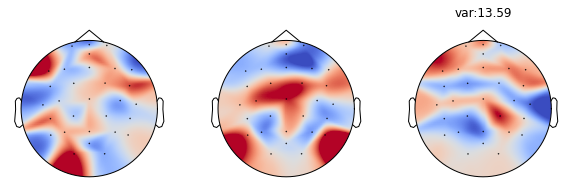

In [12]:
show_pca(info_eeg, eeg_data, n_components=3)

# 4 - Obtención de features

Estos datos corresponden a 1 archivo de 1 persona

In [13]:
eeg_data.shape

(30, 7681)

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{U_{i}}$   donde $c$ es la cantidad total de canales y $U_{i}$ es la medición del i-ésimo canal.

Entonces el *average reference* se calcula $u_i=U_i-\bar{u}$

In [14]:
u_mean=np.mean(eeg_data, axis=0)  # axis=0 calcula para cada n-esima muestra
u_mean.shape

(7681,)

In [15]:
u_i=eeg_data-u_mean

De acuerdo a la referencia el *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}u_{i}^2}$  y es equivalente al desvio estándar de los electrodos (en un cierto tiempo *t* o muestra *n*).

In [16]:
GFP=np.sqrt(1/30*np.sum(u_i**2,axis=0))

In [ ]:
#sx_std=np.std(u_i,axis=0) # coincide con el cálculo de GFP como era previsible

In [17]:
len(GFP)

7681

defino el tiempo

In [18]:
t=np.arange(0,60.005,1/srate)

In [19]:
len(t)

7681

Las otras figuras de sección previa están ploteadas entre 1 y 4 segundos. Sin embargo se tienen datos durante 60 segundos. La varianza obtenida se dibuja para el tiempo total. 

In [20]:
srate*150*1e-3

19.2

Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

In [21]:
8/srate

0.0625

In [47]:
peaks, _ = find_peaks(GFP, height=0,prominence=1,distance=8)

valores mínimos y máximos entre picos consecutivos

In [57]:
print("Cantidad de picos de GCP:", len(peaks))
print("El intervalo temporal entre máximos de GCP promedio es:",60/len(peaks),'ms')
print("El intervalo temporal entre máximos de GCP más chico es:",min(np.diff(peaks))/128,'ms')
print("El intervalo temporal entre máximos de GCP más grande es:",max(np.diff(peaks))/128,'ms')

Cantidad de picos de GCP: 554
El intervalo temporal entre máximos de GCP promedio es: 0.10830324909747292 ms
El intervalo temporal entre máximos de GCP más chico es: 0.0625 ms
El intervalo temporal entre máximos de GCP más grande es: 0.3203125 ms


Text(0.5, 0, 'Time (s)')

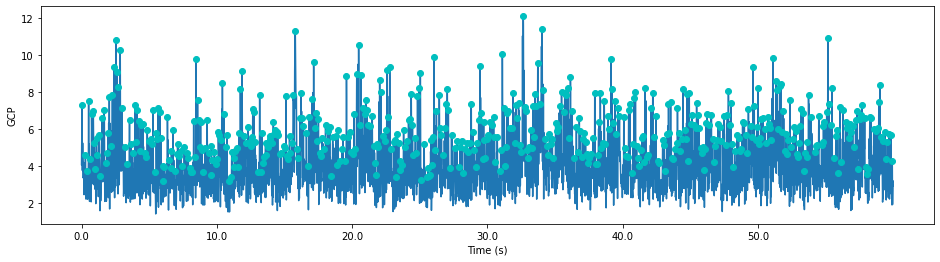

In [49]:
fig,ax=plt.subplots(ncols=1,figsize=(16,4))

xticks = np.arange(t[0],t[-1],10)
ax.plot(t,GFP)
ax.plot(t[peaks],GFP[peaks],'co')
ax.set_xticks(xticks)
ax.set_xticklabels(np.arange(t[0],t[-1],10))
ax.set_xticks(xticks)
ax.set_ylabel('GCP')
ax.set_xlabel('Time (s)')

El remuestreo se hace con los indices determinados por los picos de GCP

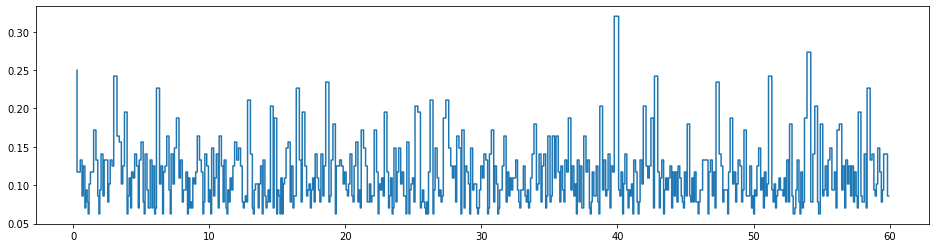

In [25]:
fig,ax=plt.subplots(ncols=1,figsize=(16,4))
plt.step(t[peaks[1:]],np.diff(t[peaks]))


Para cada indice identificados del máximo de GCP se calcula cuanto vale $u_{i}$.

In [46]:
data=np.transpose(u_i[:,peaks])

In [45]:
data.shape

(554, 30)

In [44]:
import pandas as pd
df = pd.DataFrame(data)
df.columns=mont1020_30.ch_names

In [ ]:
df

,Fp1,Fpz,Fp2,AFz,F7,F3,Fz,F4,F8,FC5,FC1,FC2,FC6,T7,C3,Cz,C4,T8,CP5,CP1,CP2,CP6,P7,P3,Pz,P4,P8,POz,O1,O2
0,1.724281,-0.005304,-1.598355,-0.818405,0.961345,0.344113,-0.306905,0.819124,-0.188762,0.077507,-0.673191,-0.715620,1.555715,1.530839,0.472827,0.744618,-0.841451,-0.381960,0.586933,-2.403607,1.863682,-2.167743,-0.241539,-0.805770,-0.098652,-1.344705,0.583083,-0.138330,0.742584,0.723650
1,1.781384,-4.168854,-0.639135,1.538414,0.595596,0.836236,-1.461536,-0.609314,1.281496,-0.495502,-0.034578,0.839786,-0.141889,-0.858470,-0.677881,-0.060768,1.496064,0.640602,0.072586,1.398872,-0.807405,-0.766416,-0.197822,0.605136,-0.176467,1.071823,-1.511495,0.251216,-0.014067,0.212388
2,0.660875,2.337081,2.012761,0.345844,-2.037061,-0.681217,1.051204,-0.321438,-0.587122,-0.118503,-0.585901,-1.441555,-0.302947,-0.105379,0.078192,-1.122496,-1.135359,-1.553971,-0.698817,0.487041,-0.979977,2.753247,-0.397990,0.615234,0.449020,1.718149,0.949078,0.190765,-1.397160,-0.181592
3,-4.203901,1.025282,0.331047,0.199162,0.379789,0.968919,2.460168,1.051588,3.131179,-1.703585,0.195491,0.930078,-0.710501,0.087718,1.887314,-0.325383,-1.291615,-1.059893,-0.984491,-0.929248,0.109704,0.933228,-0.176056,-1.389266,-0.019782,1.156827,0.297689,-1.367807,-0.115749,-0.867905
4,-2.236847,-5.789001,0.237177,-0.938706,2.022263,-1.353673,1.174043,-0.062986,2.143121,-1.775437,0.040343,2.080028,2.952990,-1.465136,-1.478175,1.465469,-2.059380,0.975575,2.832300,-0.630216,-0.058074,-0.001094,-0.011762,1.396445,1.154604,0.026036,-0.788823,-1.487933,2.233617,-0.596767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,4.401850,0.769886,0.285355,-1.266249,-3.953902,0.608872,0.502766,-1.199655,0.217600,-0.237902,1.548948,-1.357276,-0.542982,0.372582,1.010466,-2.556462,2.321733,-1.376239,-4.032923,1.831888,-2.409248,0.807342,0.597436,-1.758080,-0.196070,3.248918,-0.396655,2.616588,-1.090656,1.232076
549,1.531500,-1.554856,0.835522,-1.453665,-0.051150,-1.848844,1.629103,0.686121,1.884251,-0.007410,0.947647,0.747481,-0.102075,-0.213318,0.153855,0.659425,0.315806,0.920849,-1.352869,0.460150,3.993096,0.584167,-0.462104,-0.095502,-5.074800,-1.857707,-0.284846,-0.332594,0.190668,-0.847904
550,-1.149405,-0.676054,-1.084247,1.081285,0.394546,1.243461,0.733015,1.267750,3.869136,-0.340029,-0.482767,1.106680,-0.987923,0.722923,0.790925,0.164758,-1.079021,-0.253249,-0.225769,0.205421,3.005663,-0.356316,0.858138,0.436667,-3.648367,-0.716101,-0.382356,-0.850933,-2.675134,-0.972697
551,-0.137471,1.271364,-0.661699,-1.089993,0.365980,1.263562,-1.588639,-1.205302,-1.407060,-1.146249,0.066549,-0.414701,0.778841,1.446076,0.945215,1.566518,-1.542158,-1.758732,0.547367,-1.503990,0.583332,-0.391294,0.811392,-0.815987,1.490989,-0.516476,-0.004196,0.042511,1.724857,1.279395


Hago la misma descomposición de PCA, pero como en el dataframe quedaron en las columnas los nombres de los electrodos entonces primero aplico pca al dataset transpuesto (repito lo que hizo antes la profe).



(30, 3)


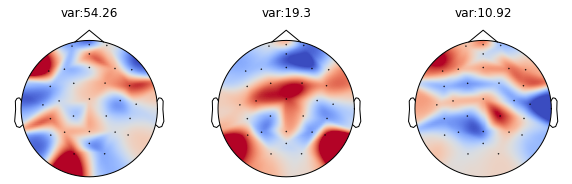

In [58]:
pca = decomposition.PCA(n_components=3)
pca.fit(np.transpose(df))
pcs = pca.transform(np.transpose(df))
print(pcs.shape)
var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )  

In [61]:
print(pcs.shape)

(30, 3)


In [68]:
var  # pca.explained_variance_ratio_

array([0.54259247, 0.19304911, 0.10922912])

In [69]:
print("las 3 primeras componentes explican un ",sum(var)*100,"% de la variabilidad")

las 3 primeras componentes explican un  84.4870695614846 % de la variabilidad


In [ ]:
#KMeans(n_clusters=6, random_state=0).fit(df)